<a href="https://colab.research.google.com/github/thatCode-Psy/MTG-Data-Analysis/blob/main/Meta_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to use, select runtime and hit run all. then modify the input fields to your desired format and date range. Data will be collected for every week between the weekday selected with the exception of the first and last week week, which will be cuttoff by those dates.

In [ ]:
# @title Imports
%matplotlib inline
from enum import Enum,unique
from dataclasses import dataclass
from datetime import date,timedelta
from IPython.display import display
from dateutil.relativedelta import *
import pandas as pd
import json,urllib.request,requests,calendar
import matplotlib.pyplot as plt

In [ ]:
# @title Helper Enums

@unique
class QueryTypes(Enum):
  EVENTS = "https://api.videreproject.com/events"
  METAGAME = "https://api.videreproject.com/metagame"
  MATCHUPS = "https://api.videreproject.com/matchups"

In [ ]:
# @title Helpers

@dataclass
class QueryParams:
  type_:QueryTypes
  additional_params:dict

class VidereQuery:
  _type:QueryTypes
  _additional_params:dict
  _limit:int
  def __init__(self,parameters:QueryParams,limit=100):
    self._type=parameters.type_.value
    self._additional_params=parameters.additional_params
    self._limit=limit

  def __str__(self) -> str:
    url = self._type + "?"
    for key in self._additional_params:
      url += key + "=" + self._additional_params[key] + "&"
    url += "limit="+self._limit.__str__()
    return url

def GenerateVidereUrlFromParams(parameters:QueryParams,limit = 100) -> str:
  query = VidereQuery(parameters,limit)
  return query.__str__()

def QueryDataFromVidere(parameters:QueryParams,limit = 100) -> list:
  url = GenerateVidereUrlFromParams(parameters=parameters, limit=limit)
  videre_data_json = requests.get(url).json()
  if("status" in videre_data_json.keys()):
    return []
  return videre_data_json["data"]

def ValidateInput(iterating_weekday:int, start_date:date, end_date:date):
  if(end_date < start_date):
    return False,"Error: You cannot have a start date after the end date"
  if((end_date - start_date).days <= 1):
    return False,"Error: Start and end dates need to be at least two days apart"
  next_weekday_from_start = start_date + relativedelta(days = 1,
                                                       weekday = iterating_weekday)

  return True

weekday_map = {"Sunday":calendar.SUNDAY, "Monday":calendar.MONDAY,
               "Tuesday":calendar.TUESDAY, "Wednesday":calendar.WEDNESDAY,
               "Thursday":calendar.THURSDAY, "Friday":calendar.FRIDAY,
               "Saturday":calendar.SATURDAY}

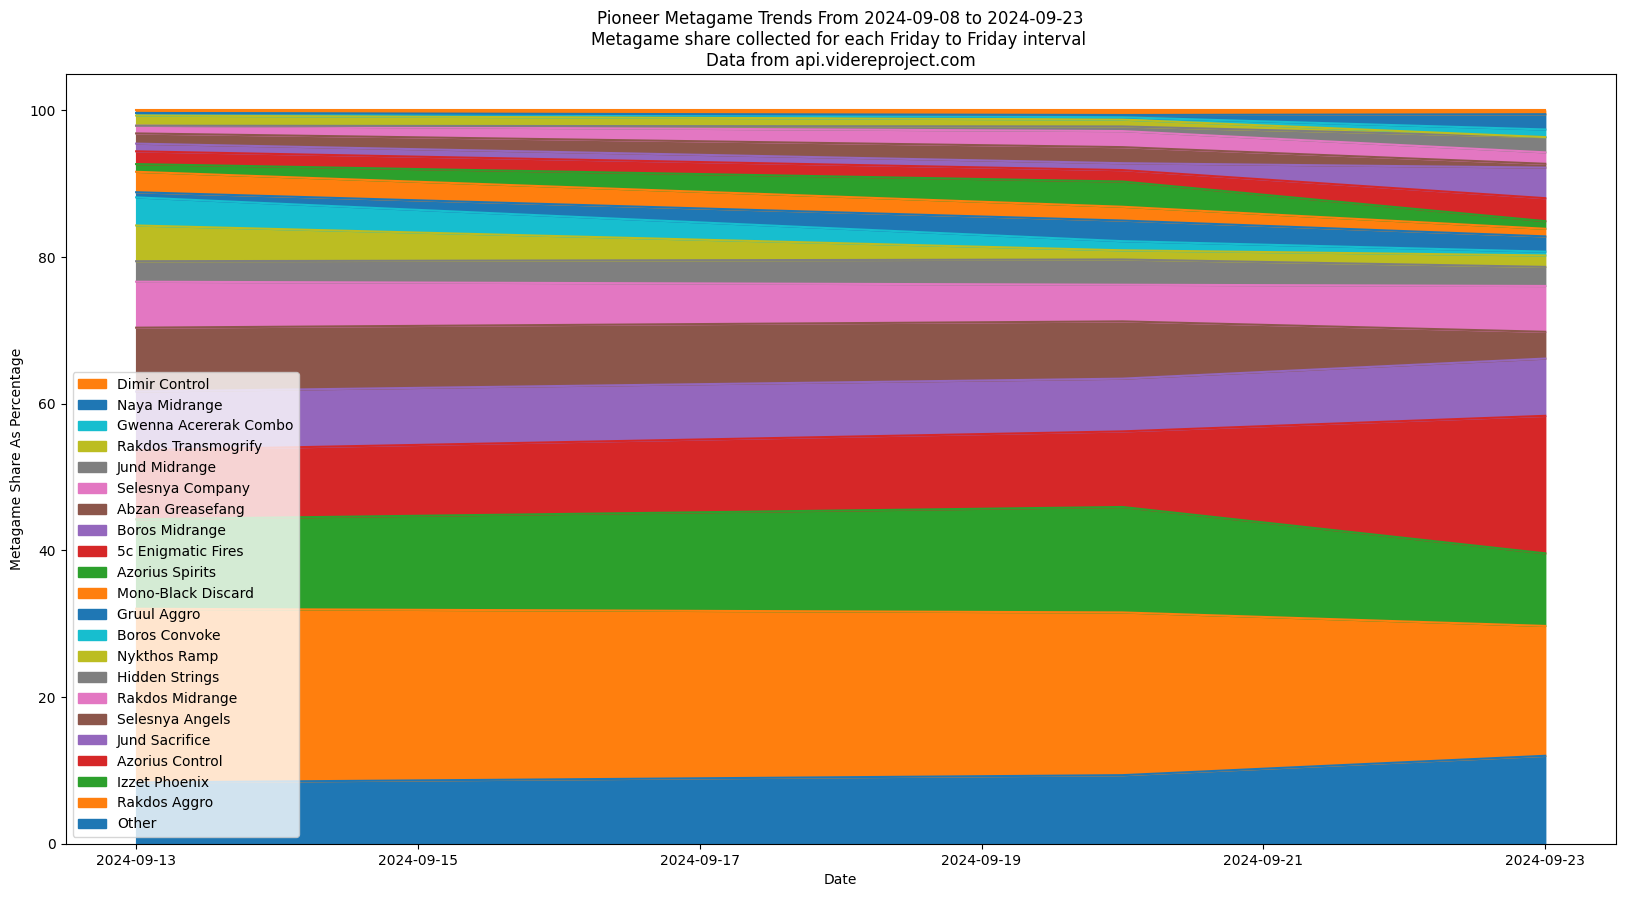

In [ ]:
# @title Inputs {run : "auto"}
def CollectMetagameDataForTimeRange(data: dict, archetype_list:list, format:str,
                                    iterating_weekday:int, start_date:date,
                                    end_date:date, limit = 100):


  query_params = QueryParams(QueryTypes.METAGAME, {
      "format":format,
      "min_date":current_date.isoformat(),
      "max_date":next_day_of_weekday.isoformat()
  })

  videre_data = QueryDataFromVidere(parameters = query_params,limit = limit)
  if videre_data is []:
    return
  week_count = len(data["timestamps"])
  data["timestamps"].append(end_date)
  for archetype in archetype_list:
    data[archetype].append(0)
  other_percentage = float(100)
  for archetype_listing in videre_data:
    archetype_name = archetype_listing["archetype"]
    if archetype_name in archetype_list:
      metagame_share = float(archetype_listing["percentage"].strip("%"))
      other_percentage -= metagame_share
      data[archetype_name][week_count] += metagame_share
  data["Other"].append(other_percentage)


default_start_date = (date.today() + timedelta(days=-31)).isoformat()
default_end_date = date.today().isoformat()
format = "Pioneer" # @param ["Standard", "Modern", "Pioneer", "Vintage", "Legacy", "Pauper"]
weekday_to_iterate_with = "Friday" # @param ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
start_date_str = "2024-09-08" # @param {type:"date"}
end_date_str = "2024-09-23" # @param {type:"date"}
archetype_limit = 21 # @param {type:"slider", min:6, max:24, step:1}

start_date = date.fromisoformat(start_date_str)
end_date = date.fromisoformat(end_date_str)
iterating_weekday = weekday_map[weekday_to_iterate_with]

validation_res = ValidateInput(iterating_weekday=iterating_weekday,
                               start_date=start_date, end_date=end_date)
if(validation_res is not True):
  print(validation_res[1])
else:
  data = {"timestamps" : [], "Other" : []}
  archetype_list = []
  query_params = QueryParams(QueryTypes.METAGAME, {
      "format":format,
      "min_date":start_date.isoformat(),
      "max_date":end_date.isoformat()
  })
  videre_data = QueryDataFromVidere(parameters = query_params,limit = archetype_limit)
  for archetype_listing in videre_data:
    data[archetype_listing["archetype"]] = []
    archetype_list.append(archetype_listing["archetype"])

  current_date = start_date
  next_day_of_weekday = current_date + relativedelta(days = 1,
                                                     weekday = iterating_weekday)

  while next_day_of_weekday<end_date:

    CollectMetagameDataForTimeRange(data, archetype_list, format,
                                    iterating_weekday, current_date,
                                    next_day_of_weekday)
    current_date = next_day_of_weekday
    next_day_of_weekday = current_date + relativedelta(days = 1,
                                                     weekday = iterating_weekday)
  CollectMetagameDataForTimeRange(data, archetype_list, format, iterating_weekday, current_date, end_date)
  plot_title = str.format("{format} Metagame Trends From {start_date} to {end_date}\nMetagame share collected for each {weekday_name} to {weekday_name} interval \nData from api.videreproject.com",
                          format = format, start_date = start_date_str,
                          end_date = end_date_str, weekday_name = weekday_to_iterate_with)
  dataFrame = pd.DataFrame(data = data)
  dataFrame.plot(kind="area", x="timestamps", figsize=(20,10), title=plot_title,
                 xlabel="Date", ylabel="Metagame Share As Percentage")
  plt.legend(loc="lower left", reverse=True)

In [ ]:
""

''